In [1]:
from keras import backend as K, initializers, regularizers, constraints
from keras.backend import image_data_format
from keras.backend.tensorflow_backend import _preprocess_conv2d_input, _preprocess_padding
from keras.engine.topology import InputSpec
import tensorflow as tf
from keras.layers import Conv2D
from keras.legacy.interfaces import conv2d_args_preprocessor, generate_legacy_interface
from keras.utils import conv_utils
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, \
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.engine.topology import get_source_inputs
#from depthwise_conv2d import DepthwiseConvolution2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils
from keras import regularizers, optimizers
from keras.optimizers import SGD
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import random
#import cv2
from sklearn.preprocessing import LabelEncoder
from skimage import io, transform
from sklearn.metrics import accuracy_score
from scipy import misc
import numpy as np

Using TensorFlow backend.


In [2]:
# This code mostly is taken form Keras: Separable Convolution Layer source code and changed according to needs.


def depthwise_conv2d_args_preprocessor(args, kwargs):
    converted = []
    if 'init' in kwargs:
        init = kwargs.pop('init')
        kwargs['depthwise_initializer'] = init
        converted.append(('init', 'depthwise_initializer'))
    args, kwargs, _converted = conv2d_args_preprocessor(args, kwargs)
    return args, kwargs, converted + _converted

legacy_depthwise_conv2d_support = generate_legacy_interface(
    allowed_positional_args=['filters', 'kernel_size'],
    conversions=[('nb_filter', 'filters'),
                 ('subsample', 'strides'),
                 ('border_mode', 'padding'),
                 ('dim_ordering', 'data_format'),
                 ('b_regularizer', 'bias_regularizer'),
                 ('b_constraint', 'bias_constraint'),
                 ('bias', 'use_bias')],
    value_conversions={'dim_ordering': {'tf': 'channels_last',
                                        'th': 'channels_first',
                                        'default': None}},
    preprocessor=depthwise_conv2d_args_preprocessor)


class DepthwiseConv2D(Conv2D):

    @legacy_depthwise_conv2d_support
    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 depth_multiplier=1,
                 activation=None,
                 use_bias=True,
                 depthwise_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 depthwise_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 depthwise_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(DepthwiseConv2D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            bias_constraint=bias_constraint,
            **kwargs)

        self.depth_multiplier = depth_multiplier
        self.depthwise_initializer = initializers.get(depthwise_initializer)
        self.depthwise_regularizer = regularizers.get(depthwise_regularizer)
        self.depthwise_constraint = constraints.get(depthwise_constraint)

    def build(self, input_shape):
        if len(input_shape) < 4:
            raise ValueError('Inputs to `SeparableConv2D` should have rank 4. '
                             'Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = 3
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs to '
                             '`SeparableConv2D` '
                             'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        depthwise_kernel_shape = (self.kernel_size[0],
                                  self.kernel_size[1],
                                  input_dim,
                                  self.depth_multiplier)

        self.depthwise_kernel = self.add_weight(
            shape=depthwise_kernel_shape,
            initializer=self.depthwise_initializer,
            name='depthwise_kernel',
            regularizer=self.depthwise_regularizer,
            constraint=self.depthwise_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):

        if self.data_format is None:
            data_format = image_data_format()
        if self.data_format not in {'channels_first', 'channels_last'}:
            raise ValueError('Unknown data_format ' + str(data_format))

        x = _preprocess_conv2d_input(inputs, self.data_format)
        padding = _preprocess_padding(self.padding)
        strides = (1,) + self.strides + (1,)

        outputs = tf.nn.depthwise_conv2d(inputs, self.depthwise_kernel,
                                         strides=strides,
                                         padding=padding,
                                         rate=self.dilation_rate)

        if self.bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            rows = input_shape[2]
            cols = input_shape[3]
        elif self.data_format == 'channels_last':
            rows = input_shape[1]
            cols = input_shape[2]

        rows = conv_utils.conv_output_length(rows, self.kernel_size[0],
                                             self.padding,
                                             self.strides[0])
        cols = conv_utils.conv_output_length(cols, self.kernel_size[1],
                                             self.padding,
                                             self.strides[1])
        if self.data_format == 'channels_first':
            return (input_shape[0], self.filters, rows, cols)
        elif self.data_format == 'channels_last':
            return (input_shape[0], rows, cols, self.filters)

    def get_config(self):
        config = super(DepthwiseConv2D, self).get_config()
        config.pop('kernel_initializer')
        config.pop('kernel_regularizer')
        config.pop('kernel_constraint')
        config['depth_multiplier'] = self.depth_multiplier
        config['depthwise_initializer'] = initializers.serialize(self.depthwise_initializer)
        config['depthwise_regularizer'] = regularizers.serialize(self.depthwise_regularizer)
        config['depthwise_constraint'] = constraints.serialize(self.depthwise_constraint)
        return config

DepthwiseConvolution2D = DepthwiseConv2D


In [3]:

'''Google MobileNet model for Keras.
# Reference:
- [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)
'''

#def MobileNet(input_tensor=None, input_shape=None, alpha=1, shallow=False, classes=1000):
#     """Instantiates the MobileNet.Network has two hyper-parameters
#         which are the width of network (controlled by alpha)
#         and input size.
        
#         # Arguments
#             input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
#                 to use as image input for the model.
#             input_shape: optional shape tuple, only to be specified
#                 if `include_top` is False (otherwise the input shape
#                 has to be `(224, 224, 3)` (with `channels_last` data format)
#                 or `(3, 224, 244)` (with `channels_first` data format).
#                 It should have exactly 3 inputs channels,
#                 and width and height should be no smaller than 96.
#                 E.g. `(200, 200, 3)` would be one valid value.
#             alpha: optional parameter of the network to change the 
#                 width of model.
#             shallow: optional parameter for making network smaller.
#             classes: optional number of classes to classify images
#                 into.
#         # Returns
#             A Keras model instance.

#         """

#     input_shape = _obtain_input_shape(input_shape,
#                                       default_size=224,
#                                       min_size=96,
#                                       data_format=K.image_data_format(),
#                                       include_top=True)
    
#     if input_tensor is None:
#         img_input = Input(shape=input_shape)
#     else:
#         if not K.is_keras_tensor(input_tensor):
#             img_input = Input(tensor=input_tensor, shape=input_shape)
#         else:
#             img_input = input_tensor
def MobileNet( alpha=1, shallow=False, classes=4):
    img_input = Input(shape=(227,227,3))
    x = Convolution2D(int(32 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(32 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(64 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(64 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if not shallow:
        for _ in range(5):
            x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(1024 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(1024 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(1024 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    out = Dense(classes, activation='softmax')(x)

#     if input_tensor is not None:
#         inputs = get_source_inputs(input_tensor)
#     else:
#         inputs = img_input

    model = Model(img_input, out, name='mobilenet')

    return model

In [4]:
def loadData(IMAGE_SIZE):
    images = os.listdir(DATA_DIR)
    d = {} 
    data_all=[]
    train_data = []
    train_pics=[]
    train_labels = []
    test_data=[]
    test_pics=[]
    test_labels=[]
    for idx, dir in enumerate(os.listdir(DATA_DIR)):
            d[idx] = dir
            label = idx
            subdir = os.path.join(DATA_DIR, dir)
            for i, file in enumerate(os.listdir(subdir)):
                #pic = cv2.imread(os.path.join(subdir, file))
                
                pic = misc.imread(os.path.join(subdir, file))
                pic = misc.imresize(pic, (IMAGE_SIZE,IMAGE_SIZE, 3))
                data_all.append((pic, label))
    np.random.shuffle(data_all)
    validation_size = int(len(data_all) * 0.40)
    #validation_data = data_all[:validation_size].copy()
    test_size = int(validation_size * 0.50)
    test_data = data_all[:test_size].copy()
    np.random.shuffle(test_data)
    #np.random.shuffle(validation_data)
    train_data = data_all[test_size:]
    for i in range(len(train_data)):
        train_pics.append(train_data[i][0])
        train_labels.append(train_data[i][1])
    for i in range(len(test_data)):
        test_pics.append(test_data[i][0])
        test_labels.append(test_data[i][1])
    return np.array(train_pics), np.array(train_labels),np.array(test_pics), np.array(test_labels)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 6400 samples, validate on 1600 samples
Epoch 1/5
6400/6400 [==============================] - 5382s 841ms/step - loss: 1.4562 - acc: 0.4989 - val_loss: 7.2488 - val_acc: 0.2288

Epoch 00001: val_acc improved from -inf to 0.22875, saving model to G:\科研\数据集\opendata_VRID\weights.best.hdf5
Epoch 2/5
6400/6400 [==============================] - 5216s 815ms/step - loss: 0.4616 - acc: 0.8609 - val_loss: 0.3634 - val_acc: 0.8788

Epoch 00002: val_acc improved from 0.22875 to 0.87875, saving model to G:\科研\数据集\opendata_VRID\weights.best.hdf5
Epoch 3/5
6400/6400 [==============================] - 5219s 815ms/step - loss: 0.2126 - acc: 0.9400 - val_loss: 0.2959 - val_acc: 0.9038

Epoch 00003: val_acc improved from 0.87875 to 0.90375, saving model to G:\科研\数据集\opendata_VRID\weights.best.hdf5
Epoch 4/5
6400/6400 [==============================] - 5346s 835ms/step - loss: 0.1212 - acc: 0.9672 - val_loss: 2.8647 - val_acc: 0.5625

Epoch 00004: val_acc did not improve from 0.90375
Epoch 5/5


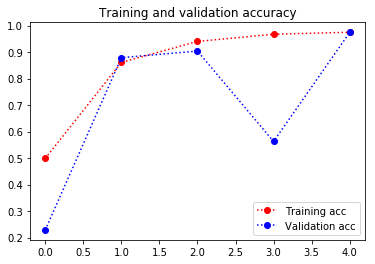

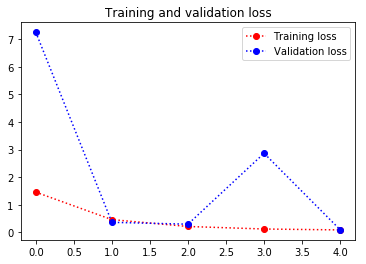

In [5]:
#np.random.seed(3)
#加载数据
IMAGE_SIZE = 227
DATA_DIR = r"G:\科研\数据集\opendata_VRID\model"
train_data, train_labels, test_data, test_labels = loadData(IMAGE_SIZE)
#输出训练和测试数据量
# print ("Train data size: ", len(train_data))
# print ("Test data size: ", len(test_data))

train_data=train_data.astype(np.float16)/255
test_data=test_data.astype(np.float16)/255
#将标签量进行转化
train_labels=np_utils.to_categorical(train_labels)
test_labels=np_utils.to_categorical(test_labels)
#设置检查点
# filepath=r"G:\科研\数据集\opendata_VRID\model\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
#设置最佳检查点
filepath=r"G:\科研\数据集\opendata_VRID\weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#设置模型
num_classes=10
model=MobileNet( alpha=1, shallow=False, classes=num_classes)
#编译模型
epochs = 5
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum,  decay=decay_rate, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

#匹配模型
#lrate = LearningRateScheduler(step_decay)
#callbacks_list = [lrate]
history=model.fit(train_data, train_labels,validation_split=0.2, nb_epoch=epochs,batch_size=16,callbacks=callbacks_list)
#测试模型
preds = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print (accuracy_score(test_labels, preds))
#保存模型
#model.save('squeeze-model(10,64).model')
#记录模型日志
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
#画模型准确率曲线和损失率曲线
plt.plot(epochs, acc, 'ro:', label='Training acc')
plt.plot(epochs, val_acc, 'bo:', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro:', label='Training loss')
plt.plot(epochs, val_loss, 'bo:', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('graph.png')